In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *
import xesmf as xe

# **Compute weather types following Rob Neal's method**

Could we use linear combinations of weather patterns to identify whether there's a clear regime or not?

## **ERA5**

### **Regrid data to required resolution & domain**

In [3]:
# load weather type patterns (predetermined by Met Office)
wp = wrap_lon(xr.open_dataset("wp_definitions_mean_anoms_emulate_1850_2003.nc").met_office_pmsl_anomaly_weather_regime_definitions_for_the_set_of_30)

# load ERA5 MSLP and cut to about the right size
era5 = wrap_lon(xr.open_dataset("../../Data/era5/era5_msl_daily.nc").msl).sel(lon = slice(-35,25), lat = slice(30,75))

# create regridder (use conservative regridding, because upscaling) 
regrid_era5 = xe.Regridder(era5, wp, "conservative")

In [ ]:
# regrid ERA5 to weather pattern domain - ~2m per year so regrid & save individual years
for y in range(1950,2024):
    print(y, datetime.now())
    if os.path.exists("era5_regridded/era5_regridded_"+str(y)+".nc"): continue
    era5_rg = regrid_era5(era5.sel(time = str(y)))
    era5_rg.to_netcdf("era5_regridded/era5_regridded_"+str(y)+".nc")
print("----", datetime.now())

### **Compute weather types from regridded data**

In [22]:
# load weather type patterns & regridded pressure fields
wp = wrap_lon(xr.open_dataset("wp_definitions_mean_anoms_emulate_1850_2003.nc").met_office_pmsl_anomaly_weather_regime_definitions_for_the_set_of_30)
era5 = convert_units_to(xr.open_mfdataset("era5_regridded/era5_regridded_*.nc")["__xarray_dataarray_variable__"].rename("msl").assign_attrs(units = "Pa"), "hPa").load()

In [20]:
# smooth the full time series & compute climatology
era5_clim = era5.rolling(time = 3, center = True).mean().rolling(time = 15, center = True).mean().rolling(time = 31, center = True).mean().sel(time = slice(None, "2000")).groupby("time.dayofyear").mean()
era5_anom = era5.groupby("time.dayofyear") - era5_clim

In [20]:
# assign weather type based on least squared difference (this is the method used by the Met Office)
era5_wss = ((era5_anom - wp)**2).weighted(np.cos(wp.latitude * np.pi/180)).sum(["latitude", "longitude"])
wt_wss = era5_wss.idxmin("regime").rename("wt_wss")

#### **Correlation vs sum of squares**

In [28]:
# get correlations & area-weighted sums of squares
era5_corrs = xr.corr(wp, era5_anom, dim = ["latitude", "longitude"])
wt_corr = era5_corrs.idxmax("regime").rename("wt_corr")

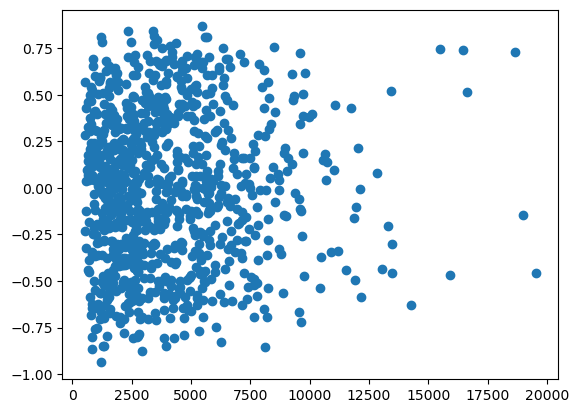

In [138]:
plt.scatter(era5_wss.sel(time = "2022-07"), era5_corrs.sel(time = "2022-07"))

In [70]:
tmax = pd.read_csv("../../xaida/2022-UK-heatwave/data/CET-tmax-daily.txt", sep = " +", engine = "python", index_col = 0, parse_dates = True)

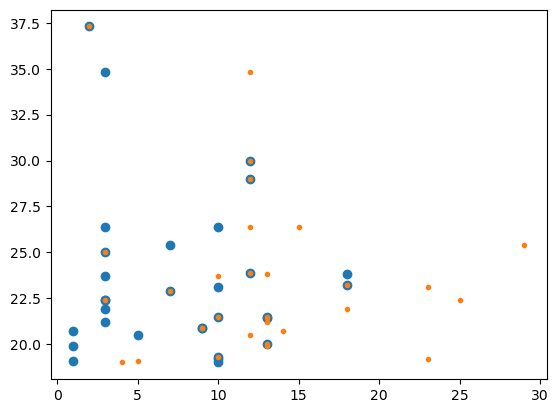

In [97]:
# temperature vs weather type
plt.scatter(wt_wss.sel(time = "2022-07"), tmax.loc["2022-07"])
plt.scatter(wt_corr.sel(time = "2022-07"), tmax.loc["2022-07"], marker = ".")

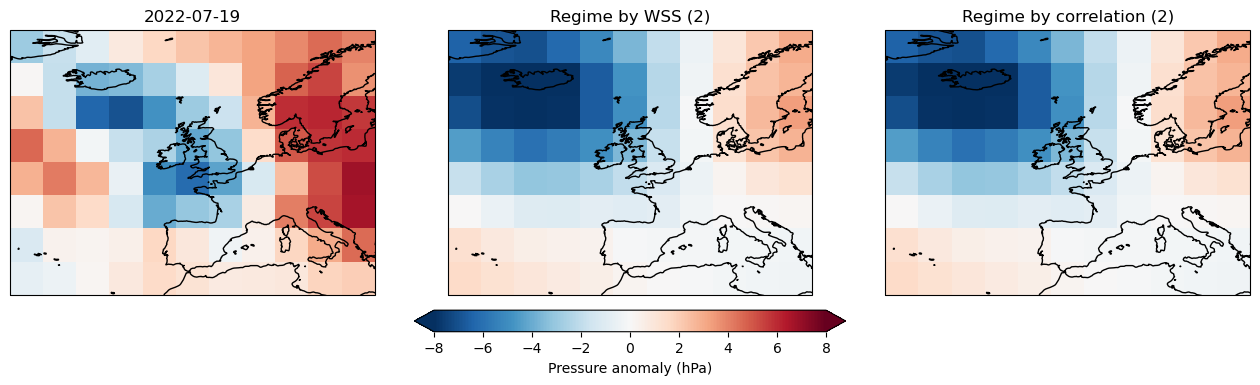

In [154]:
d = "2022-07-19"

fig, axs = plt.subplots(ncols = 3, figsize = (16,4), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
plot_kwargs = {"vmin" : -8, "vmax" : 8, "cmap" : "RdBu_r", "add_colorbar" : False}

cbar = era5_anom.sel(time = d).plot(ax = axs[0], **plot_kwargs)
wp.sel(regime = wt_wss.sel(time = d)).plot(ax = axs[1], **plot_kwargs)
wp.sel(regime = wt_corr.sel(time = d)).plot(ax = axs[2], **plot_kwargs)

axs[0].set_title(d)
axs[1].set_title("Regime by WSS ("+str(int(wt_wss.sel(time = d).values))+")")
axs[2].set_title("Regime by correlation ("+str(int(wt_corr.sel(time = d).values))+")")

for ax in axs: ax.coastlines()

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.07, extend = "both", pad = 0.05, label = "Pressure anomaly (hPa)")

In [143]:
wt_wss.where(wt_wss == 1).sel(time = "2022-07").dropna("time", "all")

<xarray.DataArray 'wt_wss' (time: 3)>
array([1., 1., 1.])
Coordinates:
  * time       (time) datetime64[ns] 2022-07-01 2022-07-25 2022-07-26
    dayofyear  (time) int64 182 206 207
Attributes:
    regrid_method:  conservative
    units:          hPa